In [1]:
import pandas as pd
import numpy as np

import torch

from fastai.vision.all import *
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
torch.cuda.empty_cache()


True


## Helper Functions


In [28]:
def plot_class_distribution(df, label_col, save_path="class_distribution.png", top_n=None):
    plt.figure(figsize=(18, 12))
    class_counts = df[label_col].value_counts()

    if top_n is not None:
        class_counts = class_counts.head(top_n)

    class_counts.plot(kind='bar', color='steelblue')
    plt.title(f'Class Distribution in Training Data{" (Top " + str(top_n) + ")" if top_n else ""}')
    plt.ylabel('Frequency')
    plt.xlabel('Class Label')

    for index, value in enumerate(class_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
    

def plot_permutation_importance(learner, dl, metric, save_path="feature_importance.png"):
    # Extract the FastAI model
    model = learner.model

    # Define a function to make predictions using the FastAI model
    def model_fn(data):
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            return model(data).numpy()

    # Extract X and y from the dataloader
    X, y = zip(*[(batch[0], batch[1]) for batch in dl])
    X = torch.cat(X)
    y = torch.cat(y).numpy()

    # Create a Permutation Importance object
    perm = PermutationImportance(model_fn, scoring=metric).fit(X.numpy(), y)
    
    # Display the feature importance
    feature_names = dl.dataset.cont_names + dl.dataset.cat_names
    eli5.show_weights(perm, feature_names=feature_names)

    # Optionally save the figure
    if save_path:
        eli5.save_weights(save_path, perm, feature_names=feature_names)


        
def plot_train_metrics(learner: Learner, save_path='train_metrics.png'):
    df = learner.csv_logger.read_log()
    df = pd.DataFrame(df, columns=['epoch', 'train_loss', 'valid_loss', 'accuracy', 'f1_score', 'error_rate', 'top_20_accuracy', 'time'])
    df['epoch'] += 1

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    df.plot(x='epoch', y=['train_loss', 'valid_loss'], ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('Train vs. Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')

    df.plot(x='epoch', y=['accuracy', 'f1_score', 'top_20_accuracy'], ax=axes[1], color=['green', 'purple', 'red'])
    axes[1].set_title('Accuracy and F1 Score')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Metrics')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def evaluate_model(
    learner,
    dls,
    test_df,
    num_to_bird_name,
    top_losses_path="top_losses.png",
    show_result_path="show_results.png",
    histogram_path="histogram.png",
    submission_file_path="submission.csv",
    show_val=15,
):
    # Update the dls.vocab to use bird names
    dls.vocab = [num_to_bird_name[i] for i in range(len(dls.vocab))]

    # Attach the updated dls to learner
    learner.dls = dls
    
    # Plot Top Losses
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_top_losses(show_val, figsize=(18, 12))
    plt.tight_layout()
    plt.savefig(top_losses_path)
    plt.show()

    # Show Results
    learner.show_results(max_n=show_val, figsize=(18, 12))
    plt.tight_layout()
    plt.savefig(show_result_path)
    plt.show()

    # Histogram of Predicted Classes
    test_dl = dls.test_dl(test_df)
    preds, _ = learner.get_preds(dl=test_dl)
    pred_labels = preds.argmax(dim=1)
    predicted_bird_names = [num_to_bird_name[label.item()] for label in pred_labels]

    # Create a DataFrame for histogram
    hist_df = pd.DataFrame({'Predicted Labels': predicted_bird_names})
    plt.figure(figsize=(18, 12))
    hist_df['Predicted Labels'].value_counts().plot(kind='bar')
    plt.title("Distribution of Predicted Labels")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(histogram_path)
    plt.show()

    # Save Submission File
    test_df['named_label'] = [num_to_bird_name[label.item()] for label in pred_labels]
    test_df['label'] = pred_labels
    test_df[["id", "label"]].to_csv(submission_file_path, index=False)
    print(f"Submission file saved to: {submission_file_path}")

    return test_df


## Load Data

image_path  label       named_label
0  /train_images/1.jpg      1  Laysan Albatross
1  /train_images/2.jpg      1  Laysan Albatross
2  /train_images/3.jpg      1  Laysan Albatross
3  /train_images/4.jpg      1  Laysan Albatross
4  /train_images/5.jpg      1  Laysan Albatross

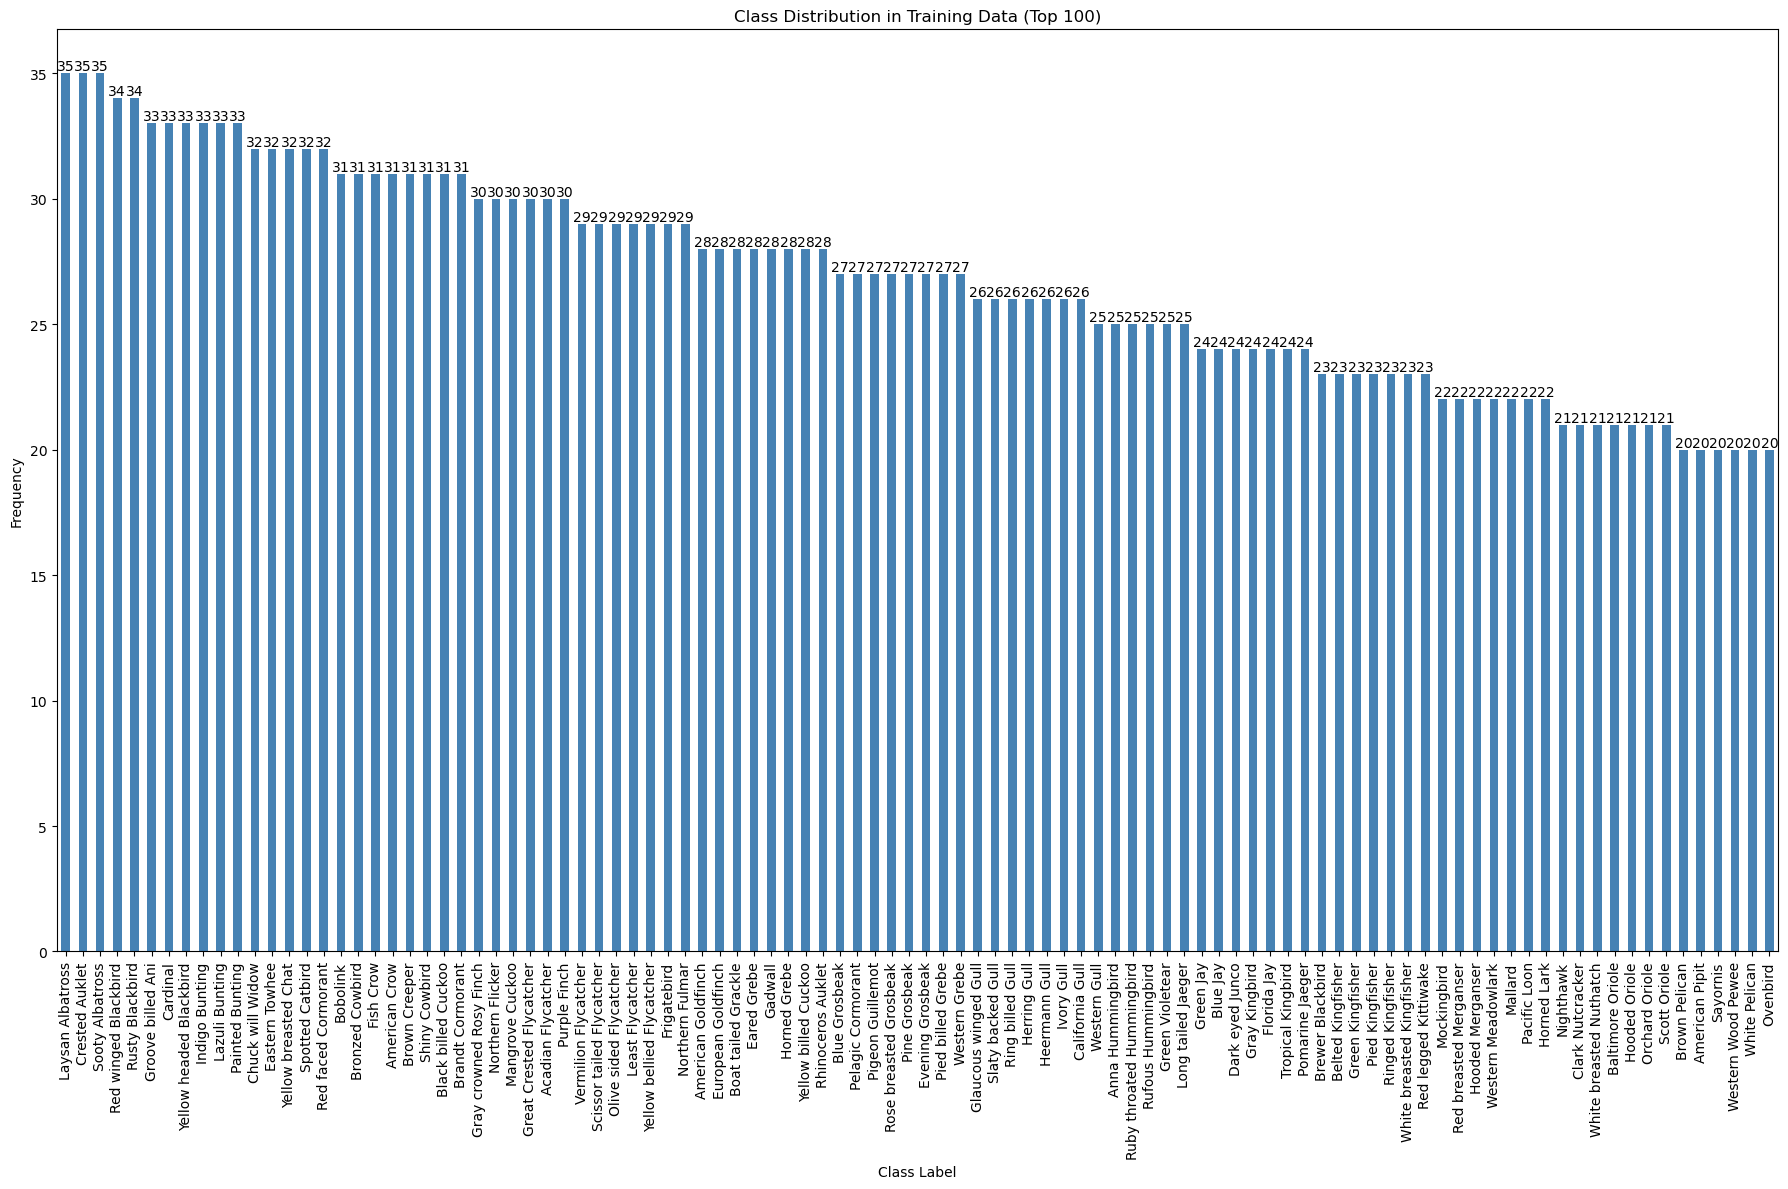

In [29]:
# LOAD DATA
class_names = np.load("class_names.npy", allow_pickle=True).item()
# Extract bird names and create a reverse mapping
num_to_bird_name = {v-1: k.split('.')[1].replace('_', ' ') for k, v in class_names.items()}

# attributes = np.load("attributes.npy", allow_pickle=True)
# attributes.shape

train_df = pd.read_csv("train_images.csv")
train_df['named_label'] = train_df['label'].map(num_to_bird_name)
display(train_df.head())
test_df = pd.read_csv("test_images_path.csv")

plot_class_distribution(train_df, 'named_label', top_n=100)

## Image Data Loader

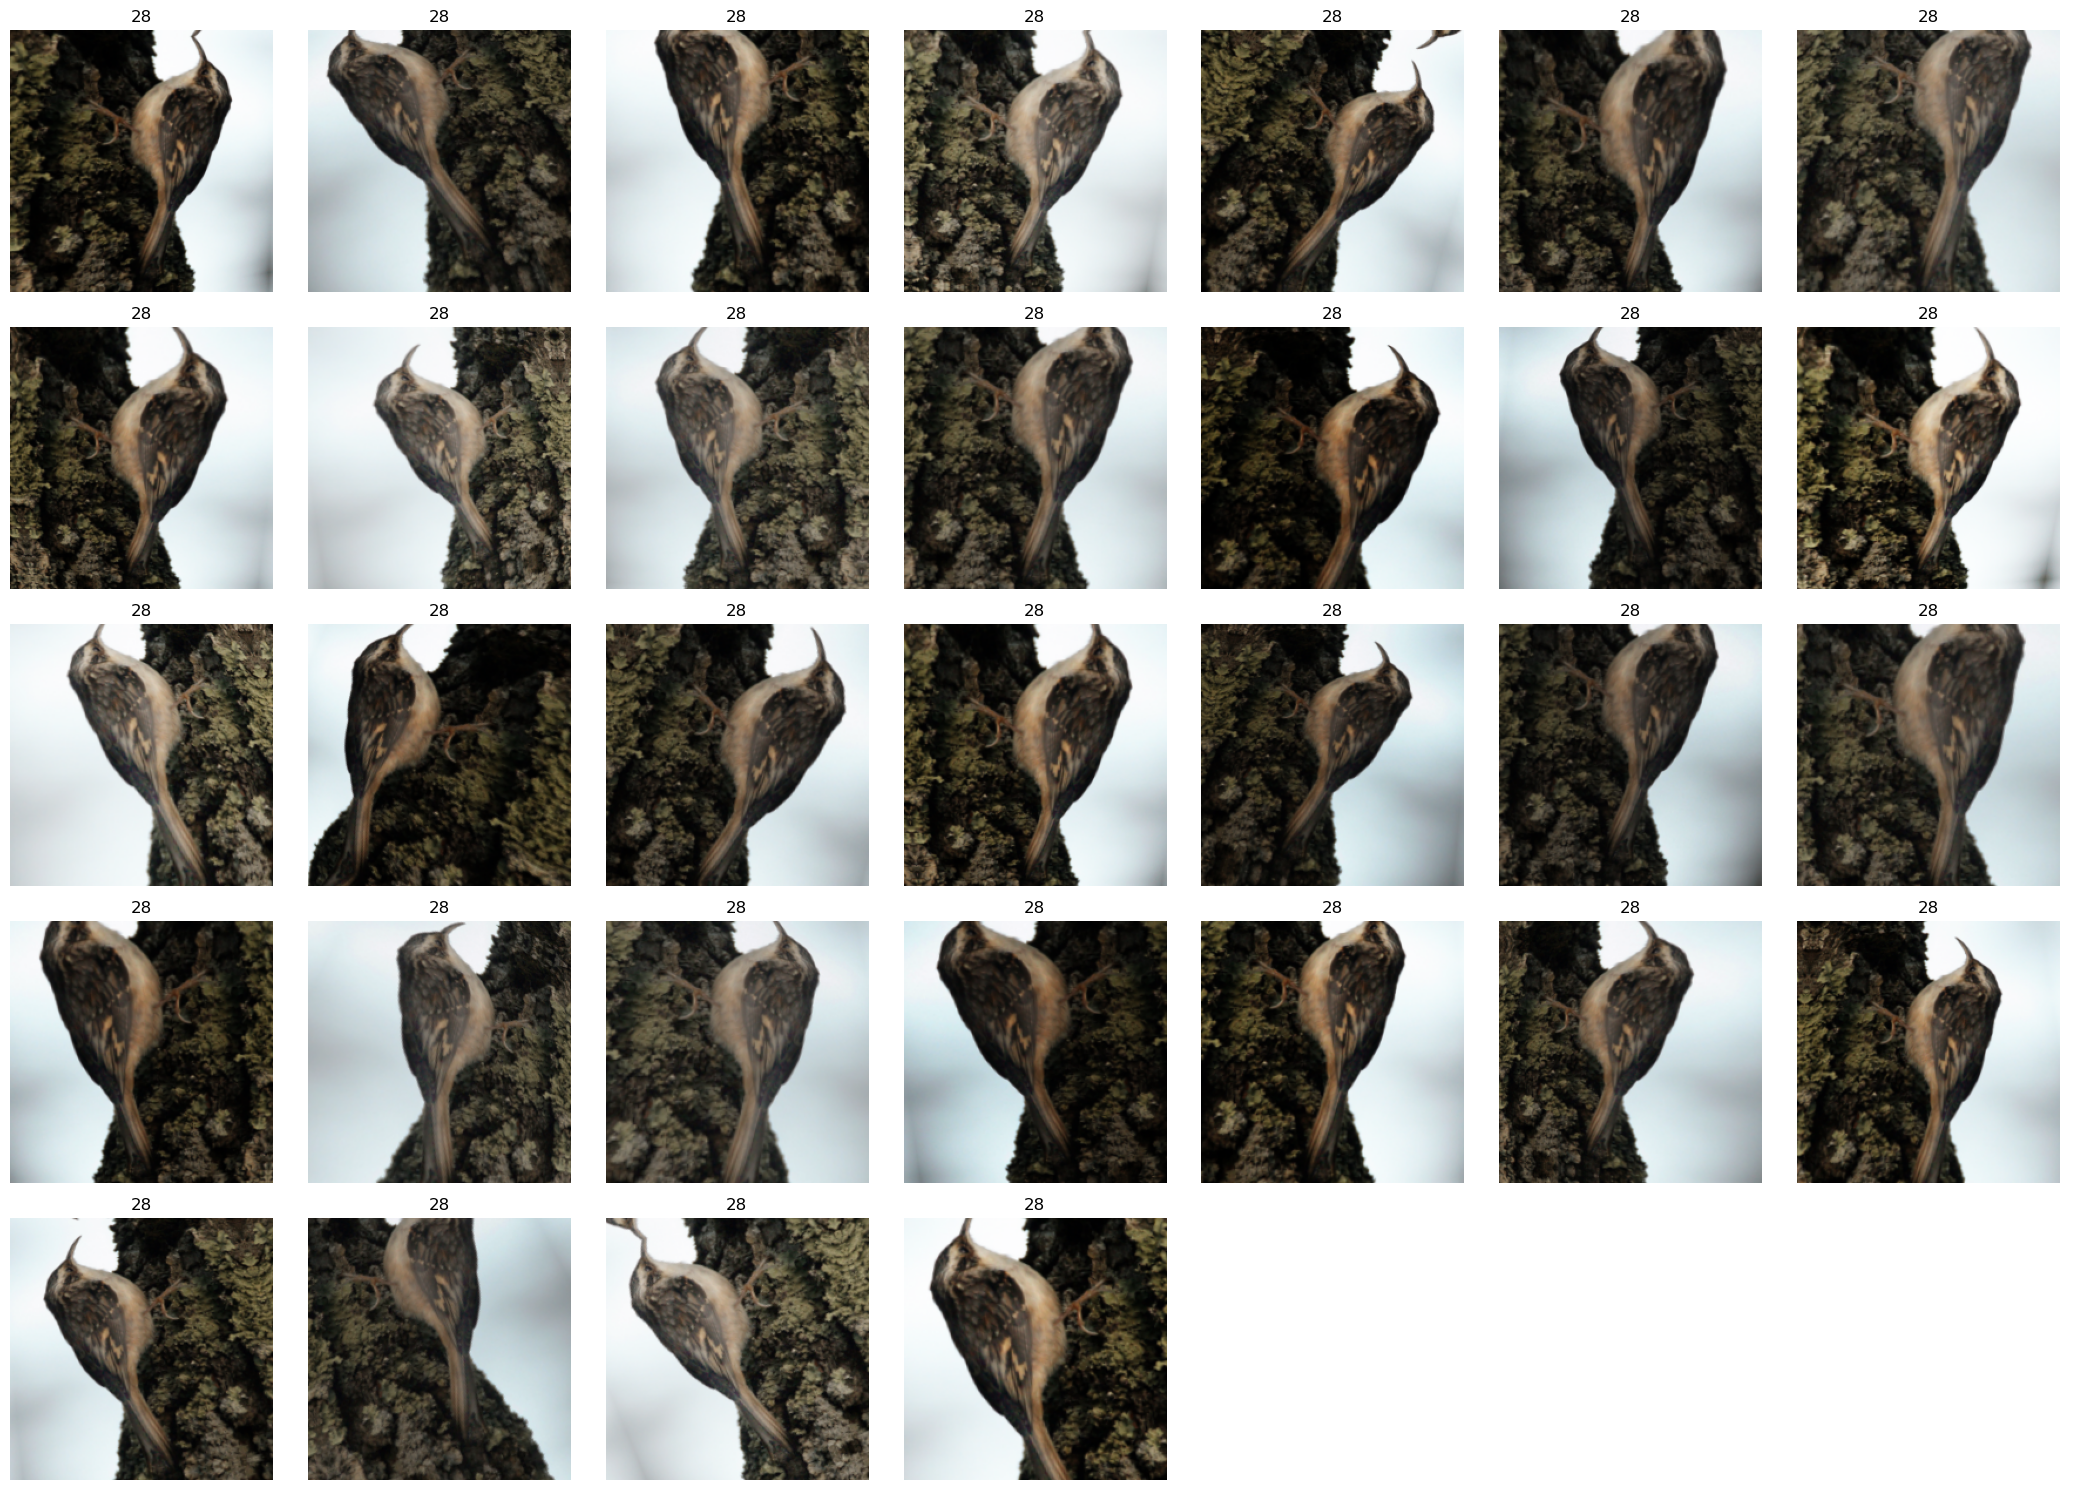

In [6]:
# INIT IMAGE DATA LOADER
 # Set up the data loaders with proper resizing in item_tfms
dls = ImageDataLoaders.from_df(
    train_df,
    valid_pct=0.2,
    bs=32,
    seed=41,
    # val_bs=32,
    shuffle=True,
    label_col="label",
    fn_col="image_path",
    y_block=CategoryBlock,
    item_tfms=RandomResizedCrop((224, 224), min_scale=0.80, max_scale=0.80),  # Random crop and resize
    batch_tfms=[
        *aug_transforms(
            do_flip=True,
            max_rotate=25,  # Slight rotation
            max_zoom=1.3,  # Slight zoom
            max_lighting=0.3,
            p_lighting=0.8,  # Probability of applying lighting changes
            xtra_tfms=[
                # Flip(p=0.1),  # Horizontal flip
                # Brightness(max_lighting=0.1, p=0.75),  # Slightly adjust brightness
                Contrast(max_lighting=0.1, p=0.75),  # Slightly adjust contrast
                Saturation(max_lighting=0.1, p=0.75),  # Slightly adjust saturation
                # Hue(max_hue=0.1, p=0.4),  # Slight hue adjustment
                # RandomErasing(p=0.2, max_count=2)  # Random erasing
            ]),
        Normalize.from_stats(*imagenet_stats)
    ]
)

dls.train.show_batch(max_n=34, unique=True)
plt.tight_layout()
# Save the figure
plt.savefig("train_batch.png", format='png', bbox_inches='tight')
# Show the plot
plt.show()




## Modelling Setup

In [34]:
# MODELLING
def train(dls, models, metrics, loss_func=CrossEntropyLossFlat(), test_df=test_df, num_to_bird_name=num_to_bird_name):
    for mdl in models:
        print(f"Trying Model: {mdl[0]}")
        # Create a directory for the current model
        model_dir = f"{mdl[0]}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Set up and train the learner
        learn = vision_learner(
            dls=dls,
            arch=mdl[1],
            weights=mdl[2],
            metrics=metrics,
            loss_func=loss_func,
            cbs=CSVLogger(fname=f"{model_dir}/metrics.csv"),
            opt_func=partial(OptimWrapper, opt=torch.optim.AdamW, lr=0.002)
        ).to_fp16()
        lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
        plt.title("Find Learning Rate")
        plt.tight_layout()
        plt.savefig(f"{model_dir}/lr_find.png", format='png', bbox_inches='tight')
        plt.show()
        
        # Use one of the suggested learning rates
        print(f"Minimum/10: {lr_min}, Steepest point: {lr_steep}")
        learn.fine_tune(10, freeze_epochs=4)
        
        plot_train_metrics(learn, save_path=f"{model_dir}/metrics.png")
        
        # Evaluate the model and save the results
        evaluate_model(
            learn,
            dls,
            test_df,
            num_to_bird_name=num_to_bird_name,
            top_losses_path=f"{model_dir}/top_losses.png",
            show_result_path=f"{model_dir}/show_results.png",
            histogram_path=f"{model_dir}/histogram.png",
            submission_file_path=f"{model_dir}/submission.csv",
            show_val=15,
        )
        
        torch.cuda.empty_cache()


models_list = [
    # ("resnet34", models.resnet34, ResNet34_Weights.DEFAULT),
    ("resnet50", models.resnet50, ResNet50_Weights.DEFAULT),
    ("resnet101", models.resnet101, ResNet101_Weights.DEFAULT),
    ("resnext50_32x4d", models.resnext50_32x4d, ResNeXt50_32X4D_Weights.DEFAULT),
    ("resnext101_32x8d", models.resnext101_32x8d, ResNeXt101_32X8D_Weights.DEFAULT),
    # ("efficientnet_v2_m", models.efficientnet_v2_m, EfficientNet_V2_M_Weights.DEFAULT),
    # ("regnet_y_3_2gf", models.regnet_y_3_2gf, RegNet_Y_3_2GF_Weights.DEFAULT) 
    # ("inception_v3", models.inception_v3, Inception_V3_Weights.DEFAULT),
    # ("mobilenet_v3_large", models.mobilenet_v3_large, MobileNet_V3_Large_Weights.DEFAULT),
]

# Metrics
f1_score = F1Score(average='weighted')
balanced_acc = BalancedAccuracy()
top_20 = partial(top_k_accuracy, k=20)
metrics = [accuracy, f1_score, top_20]


## Trying Models

Trying Model: resnet50


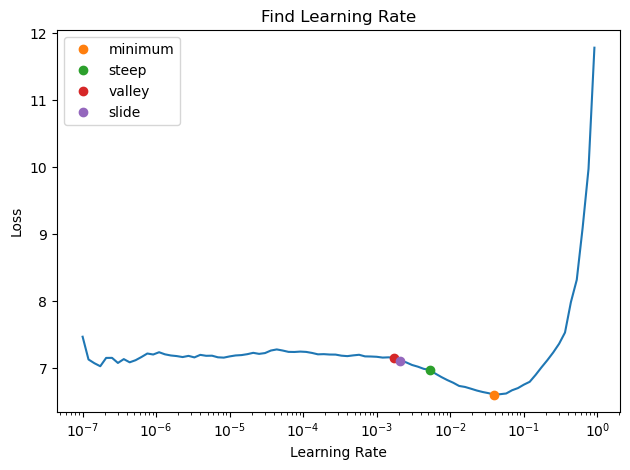

Minimum/10: 0.003981071710586548, Steepest point: 0.005248074419796467


In [ ]:
train(dls, models_list, loss_func=CrossEntropyLossFlat(), metrics=metrics)

In [ ]:
train(dls, models_list, loss_func=FocalLossFlat(gamma=3), metrics=metrics)

In [ ]:
# Assuming train_df is your DataFrame and "label" is the column with class labels
labels = train_df["label"].values  # Removed the parentheses as 'values' is a property, not a method

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Assuming train is a function you defined or imported from a specific library
# Assuming dls is your DataLoaders, models_list is a list of your models, and metrics is your metrics list
train(dls, models_list, loss_func=CrossEntropyLossFlat(weight=class_weights), metrics=metrics)